# Context

#### Datasets
In dit project zullen we gebruik maken van twee datasets. Beide datatsets zijn afkomstig van Kaggle en zijn terug te vinden op volgende links: <a href="https://www.kaggle.com/nitishabharathi/gdp-per-capita-all-countries" target="_blank">GDP per capita</a> en <a href="https://www.kaggle.com/unitednations/global-commodity-trade-statistics" target="_blank">Global Commodity Trade Statistics</a>. De eerste dataset bevat data over de gdp van alle landen in de wereld tussen 1990 en 2019. De rijen stellen de landen voor en de kolommen stellen een jaartal voor. Elke cel vertegenwoordigt dus de gdp van een land in een jaar. Het is belangrijk te vermelden dat de gdp die wordt voorgesteld in deze dataset geen nominale gdp, maar **gdp per capita gebasseerd op PPP**. PPP staat voor Purchasing Power Parity en door de gdp hierop te baseren neem je variabalen als de cost van locale goederen, inflatie, enz... mee in het opstellen van de gdp waarde. Het geeft een beter beeld over het verschil in inkomsten per capita tussen de landen. **We zullen in de rest van het onderzoek naar de GDP per capita gebasseerd op PPP verwijzen als gdp**.

De andere dataset bevat info over de handel die landen voerden tussen 1988 en 2016. Een rij stelt een handelsactie voor. Info zoals land, import of export, gewicht, hoeveelheid, waarde van de handels actie kunnen teruggevonden worden in een kolom.

#### Doel
We zullen trachten aan de hand van enkele visualisaties en tabellen een antwoord te bieden op enkele vragen. Namelijk **welk type goederen landen afnemen en verhandelen afhankelijk van hun GDP**, en of we **evoluties in de gdp ook terugzien in de data over de handel die landen hebben gedaan**. 

#### Data exploratie en manipulatie
Uit de data exploratie blijkt dat de data die we hebben niet echt fouten bevat. De manipulatie focust zich dan ook vooral op het filteren van de jaren die niet bruikbaar zijn tijdens dit project. Mits de dataset van de gdp loopt van 1990 tot 2019 en deze van trade van voor 1990 tot 2016, zullen we enkel records gebruiken tussen 1990 en 2016. 

We hebben gezegd dat we niet veel filter werk moesten verrichten om aan de slag te kunnen gaan. Eén probleem dat we niet kunnen wegfilteren is het feit dat het kan voorkomen dat een land onafhankelijk wordt in bijvoorbeeld 2004 en dat er voor alle jaren voorheen geen data aanwezig is. Dit zullen we oplossen door steeds de jaren in de grafiek aan te passen naar de beschikbare jaren. Optimaal zullen grafieken die de hele periode bestrijken gaan van 1990 tot 2016, maar het kan gebeuren dat dit niet zo is, of dat er bijvoorbeeld wel eens een jaar kan wegvallen als er daar geen data voor is. Hiermee kunnen we het onbtreken van data op een elegante manier opvangen.

In [1]:
import findspark
spark_location='C:\spark-3.1.2-bin-hadoop3.2'
findspark.init(spark_home=spark_location) 
from IPython.display import HTML
import matplotlib.pyplot as plt
from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show
from matplotlib.pyplot import figure
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import lower, col
import folium as folium
import json
from pyspark.sql.types import IntegerType

# Spark sessie aanmaken.
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()

# Inladen van csv in een dataframe. De CSV bestanden moeten zich in een folder
# in dezelfde map bevinden als deze code file.
df_gdp = spark.read.csv("./Datasets/GDP.csv", header=True)
df_trade = spark.read.csv("./Datasets/Trade.csv", header=True)
# df_gdp = spark.read.csv("C:/Users/bavo1/Documents/Academiejaar 2021 - 2022/Data mining/Data/gdp/GDP.csv", header=True)
# df_trade = spark.read.csv("C:/Users/bavo1/Documents/Academiejaar 2021 - 2022/Data mining/Data/trade/Trade.csv", header=True)

# We verwijderen records uit bepaalde jaren in de beide datasets, 
# hierdoor zullen de records in beide datasets dezelfde jaren bestrijken.
# We hernoemen enkele kolommen om het makkelijker te maken om met deze kolommen te werken.
columns_to_drop_gdp = ['2017', '2018', '2019']
df_gdp = df_gdp.drop(*columns_to_drop_gdp)
df_gdp = df_gdp.withColumnRenamed("Country ","Country")

columns_to_drop_trade = ['comm_code', 'quantity_name', 'quantity']
df_trade = df_trade.drop(*columns_to_drop_trade)
df_trade = df_trade.filter(df_trade.year > 1989).filter(df_trade.year < 2017)
df_trade = df_trade.withColumn(str("trade_usd"), df_trade["trade_usd"].cast("float"))
df_trade = df_trade.withColumn(str("weight_kg"), df_trade["weight_kg"].cast("float"))

# Initialisatie van arrays die we later zullen gebruiken voor berekeningen.
GDP_means = []
trade_usd_sum_year = []
GDP_extremes = []
GDP_extremes_country = []

# We verwijderen de eerste twee waarder, omdat deze kolom headers geen jaar vertegenwoordigde, maar wel
# landen en hun code.
years = df_gdp.columns
del years[:2]

# We verkrijgen de totale prijs van alle handel gevoerd in een jaar. Na de group by doen we een sort,
# zodat de totaal prijs overeenkomt met het juiste jaar in de year array.
df_trade_gb = df_trade.groupBy('year').sum("trade_usd")
df_trade_gb = df_trade_gb.sort(df_trade_gb["year"].asc())
trade_usd_sum_year = [row[0] for row in df_trade_gb.select("sum(trade_usd)").collect()]

# For loop voor het berekenen vaan jaar gebaseerde cijfers.
for year in years:
    
    # Gemiddelde GDP elk jaar
    year_list = [row[0] for row in df_gdp.select(year).collect()]
    year_list = [float(i) for i in year_list if i]
    year_mean = sum(year_list) / len(year_list)
    GDP_means.append(year_mean)
    
    # Min en Max GDP voor 1960 en 2016.
    if (year == years[0] or year == years[-1]):
        year_min = min(year_list)
        year_max = max(year_list)
        GDP_extremes.append((year, year_min, "min"))
        GDP_extremes.append((year, year_max, "max"))
        


# Visualisatie
We zullen twee grafieken tonen. Beide grafieken tonen op de x-as het jaar, in dit geval van 1990 tot 2016. De y-as vertegenwoordigd bij beide een andere variabele. 

De bovenste grafiek geeft een beeld van de **evolutie van de gemiddelde gdp in de wereld** doorheen de eerder vermelde periode. Merk vooral op dat de enige echt grote daling en dip te zien is in 2008. Dit valt mooi samen met de zogenoemde *Global Financial Crisis* .

De onderste grafiek toont opnieuw een evolutie, maar deze van de **totale som aan geld (in USD), die betrokken is geweest in alle handelsacties**. 

Als laatste willen we ook tonen welke landen er in 1990 de **hoogste en laagste gdp** hadden en wie dit waren op het einde van ons onderzoek namelijk in 2016.

Door deze twee grafieken onder elkaar te tonen kunnen we al een eerste algemeen beeld krijgen van hoe handel evolueert tegenover gdp.

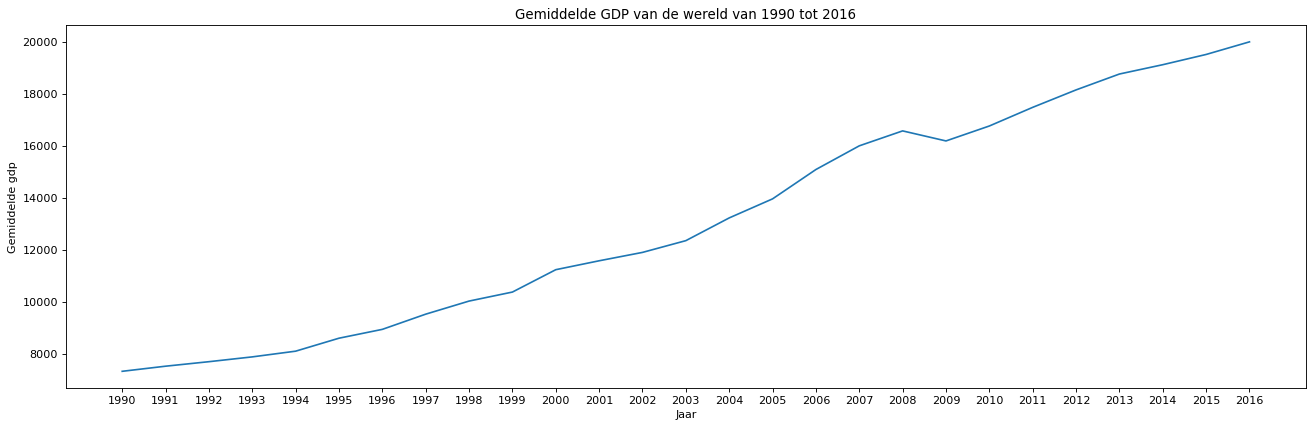

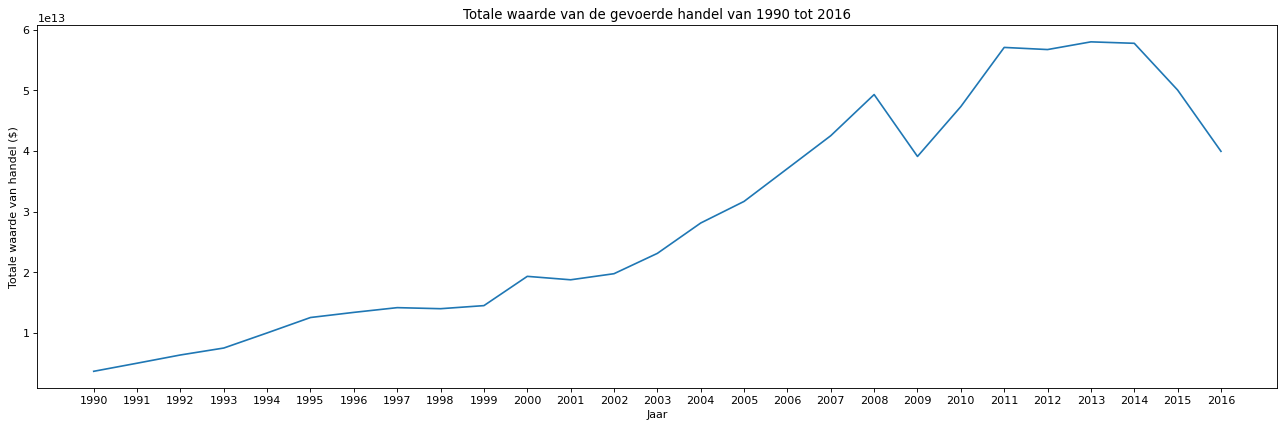

De laagste gdp in de wereld in 1990: 424.823989 in Ethiopia
De hoogste gdp in de wereld in 1990: 72906.52012 in United Arab Emirates
De laagste gdp in de wereld in 2016: 743.9035976 in Burundi
De hoogste gdp in de wereld in 2016: 123573.6308 in Qatar


In [2]:
# Het creeeren van grafieken die een al een eerste blik werpen op de data.
# De titel van de grafieken laat duidelijk zien wat ze moeten voorstellen. 
figure(figsize=(20, 6), dpi=80)
plt.plot(years, GDP_means)
plt.xlabel('Jaar')
plt.ylabel('Gemiddelde gdp')
plt.title('Gemiddelde GDP van de wereld van 1990 tot 2016')
plt.show()

figure(figsize=(20, 6), dpi=80)
plt.plot(years, trade_usd_sum_year)
plt.xlabel('Jaar')
plt.ylabel('Totale waarde van handel ($)')
plt.title('Totale waarde van de gevoerde handel van 1990 tot 2016')
plt.show()

# Achterhalen welke landen exact de hoogst en laagste gdp hebben in 1990 en 2016.
dfExtremes = df_gdp[['Country', years[0], years[-1]]]

for gdp in GDP_extremes:
    year, gdp_value, extreme = gdp
    result = dfExtremes[dfExtremes[year] == gdp_value]
    country = [(row[0]) for row in result.select("Country").collect()]
    country = ''.join([i for i in country if not i.isdigit()])
    country = country.strip()
    GDP_extremes_country.append((year, gdp_value, extreme, country))
        
print("De laagste gdp in de wereld in " + GDP_extremes_country[0][0] + ": " + str(GDP_extremes_country[0][1]) + " in " + GDP_extremes_country[0][3])
print("De hoogste gdp in de wereld in " + GDP_extremes_country[1][0] + ": " + str(GDP_extremes_country[1][1]) + " in " + GDP_extremes_country[1][3])
print("De laagste gdp in de wereld in " + GDP_extremes_country[2][0] + ": " + str(GDP_extremes_country[2][1]) + " in " + GDP_extremes_country[2][3])
print("De hoogste gdp in de wereld in " + GDP_extremes_country[3][0] + ": " + str(GDP_extremes_country[3][1]) + " in " + GDP_extremes_country[3][3])


De gebruiker zal een invulveld tegenkomen waar hij een land kan ingeven en daarbij een keuze moet maken tussen *trade per year* of *trade weight per year*. Afhankelijk van die keuze zal de tweede grafiek die getoont word, na het drukken op de load knop, een grafiek zijn die doorheen de periode 1990 tot 2016 een beeld geeft over de evolutie van het totale gewicht van de trade die het land heeft gevoerd of de totale soms van de waarde van de handel die het land gevoerd heeft. De eerste grafiek zal de evolutie tonen van de gdp van het ingevulde land doorheen de periode.

Het invulveld is niet hoofdlettergevoelig, maar vereist wel een waarde voor een bestaand land. Het invullen van een land dat niet bestaat of een foute schrijfwijze resulteert in een error. 

Door de twee grafieken te tonen kan een beeld gevormd worden hoe de handel van een specifiek land beïnvloedt wordt door haar eigen gdp. Events in een land kunnen dan makkelijker gelinkt worden aan een stijging of daling in de gdp en dan ook met gevolg misschien wel hun handel.

Het is altijd interessant om naar de linkerbovenhoek van de grafiek te kijken om dat daar eventuele machten kunnen staan die voor een schaling zorgen op de y-as.

In [18]:
# HTML code voor het creeëren van een invulveld en radiotbutton. Het invulveld is niet 
# hoofdlettergevoelig en neemt een land aan. De radiobutton laat de gebruiker de keuze om
# gewicht van de handel of totale prijs van de handel te zien.
form = """
<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
    Land : <input type="text" id="country" name="country"><br><br>
    <div>
        <input type="radio" id="trade" name="column" value="trade_usd" checked="checked">
        <label for="html">Total prijs van de handel($)</label><br>
        <input type="radio" id="weight" name="column" value="weight_kg">
        <label for="desc">Totale gewicht van de handel</label><br>
    </div>
    <hr>
    <div>
        <input type="radio" id="line" name="graph" value="line" checked="checked">
        <label for="html">Lijn grafiek</label><br>

        <input type="radio" id="bar" name="graph" value="bar">
        <label for="desc">Bar plot</label><br>
    </div>
    <div>
        <input id="submit" type="submit" value="Submit" onclick="return set_country()">
    </div>
</div>
"""
javascript = """
<script type="text/Javascript">
    function set_country(){
        var var_name1 = 'inp_country';
        var var_name2 = 'inp_column'
        var var_name3 = 'inp_graph'
        var var_value1 = document.getElementById('country').value;
        var var_value2 = document.getElementById('trade').checked;
        var var_value3 = document.getElementById('line').checked;
        var command1 = var_name1 + " = '" + var_value1 + "'";
        var command2 = var_name2 + " = '" + var_value2 + "'";
        var command3 = var_name3 + " = '" + var_value3 + "'"; 
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        kernel.execute(command2);
        kernel.execute(command3);
        cell1 = IPython.notebook.get_cell(6);
        cell1.execute();
        cell1.focus_cell(6);
    }
</script>
"""

HTML(form + javascript)

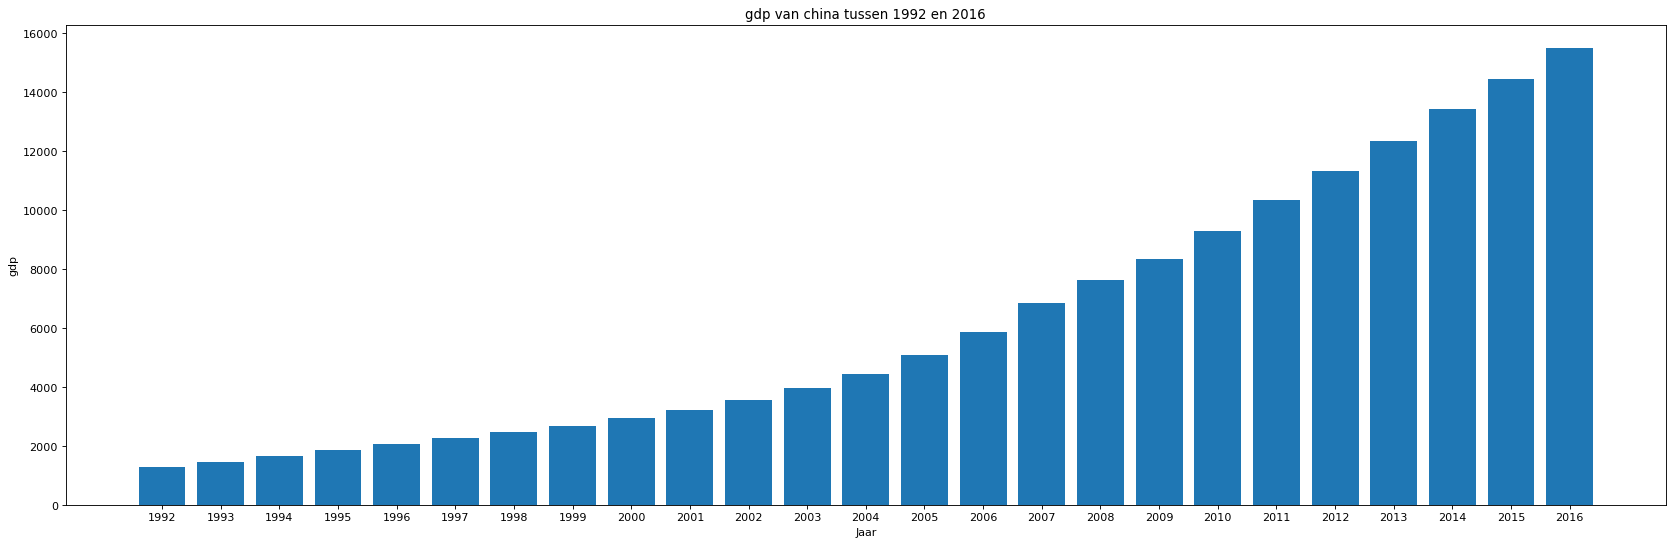

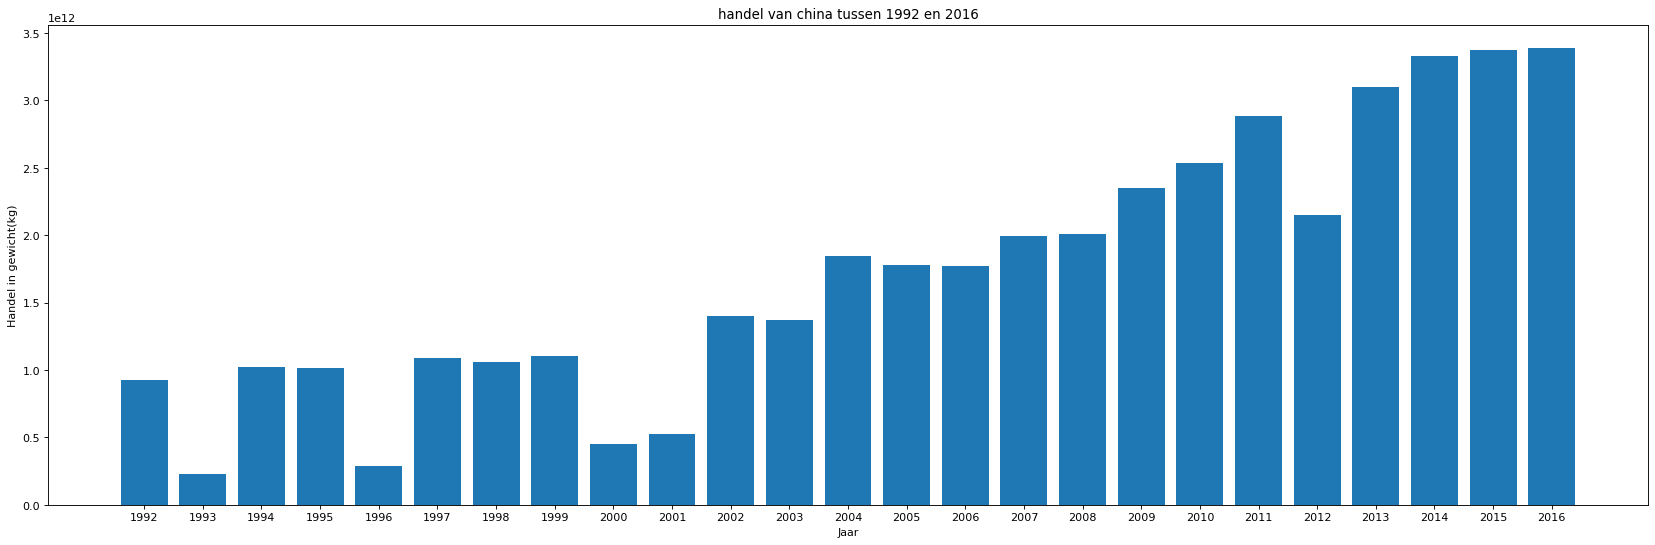

In [32]:
gdp_country = []
country_input = inp_country
# Filter op het land in het gdp dataframe. We houden geen rekening met hoofdletters.
df_gdp_country = df_gdp.filter(lower(df_gdp.Country) == country_input.lower())
df_gdp_country = df_gdp_country.drop('Country','Country Code')

# We gebruiken een variabele om dynamische de label van de y-as aan te passen.
label=""
column_input = inp_column
trade_country_sum = []

if (column_input == "true"):
    column_input = "trade_usd"
    label = "Handel in monetaire waarde($)"
else :
    column_input = "weight_kg"
    label = "Handel in gewicht(kg)"

# Filter op het land in het trade dataframe.
df_trade_country = df_trade.select("country_or_area","year",column_input)
df_trade_country = df_trade_country.filter(lower(df_trade_country.country_or_area) == country_input.lower())

# Verkijg alle handel voor een land in prijs of gewicht tussen 1990 en 2016.
# We vragen enkel de gdp op voor de jaren waar we handelsdata voor hebben.
df_country_gb = df_trade_country.groupBy('year').sum(column_input)
df_country_gb = df_country_gb.sort(df_country_gb["year"].asc())
years = [row[0] for row in df_country_gb.select("year").collect()]
trade_list = [row[0] for row in df_country_gb.select("sum(" + column_input + ")").collect()]

# De gdp voor elk jaar van het gekozen land.
for year in years:
    year_gdp = [row[0] for row in df_gdp_country.select(year).collect()]
    year_gdp = [float(i) for i in year_gdp if i]
    gdp_country.append(year_gdp)
    
    
if(inp_graph == "true"):
    # Lijngrafiek die de gdp van het land tekent doorheen de tijd.
    figure(figsize=(20, 6), dpi=80)
    plt.plot(years, gdp_country)
    plt.xlabel('Jaar')
    plt.ylabel('gdp')
    plt.title('gdp van ' + country_input + ' tussen ' + years[0] + ' en ' + years[-1])
    plt.show()

    # Lijngrafiek die de informatie over handel van het land tekent doorheen de tijd.
    figure(figsize=(20, 6), dpi=80)
    plt.plot(years, trade_list)
    plt.xlabel('Jaar')
    plt.ylabel(label)
    plt.title('handel van ' + country_input + ' tussen ' + years[0] + ' en ' + years[-1])
    plt.show()
else :
    gdp_country = [j for i in gdp_country for j in i]
    # Barplot die de gdp van het land tekent doorheen de tijd.
    fig = plt.figure(figsize=(20, 6), dpi=80)
    ax = fig.add_axes([0,0,1,1])
    ax.bar(years,gdp_country)
    ax.set_title('gdp van ' + country_input + ' tussen ' + years[0] + ' en ' + years[-1])
    ax.set_xlabel("Jaar")
    ax.set_ylabel("gdp")
    plt.show()

    # Barplot die de gdp van het land tekent doorheen de tijd.
    fig = plt.figure(figsize=(20, 6), dpi=80)
    ax = fig.add_axes([0,0,1,1])
    ax.bar(years,trade_list)
    ax.set_title('handel van ' + country_input + ' tussen ' + years[0] + ' en ' + years[-1])
    ax.set_xlabel("Jaar")
    ax.set_ylabel(label)
    plt.show()

De gebruiker kan de slider hieronder gebruiken om een jaar te selecteren. Door een jaar te selecteren zal de gebruiker enkel data terugkrijgen dat relevant is voor dat jaar. Deze slider zal er niet voor zorgen dat er grafieken getoond worden. Deze slider zal een stuk code runnen waardoor de gebruiker in een andere widget kan selecteren hoeveel rijen hij wilt zien (met een slider) en dit in ascending of descending order. Eenmaal de tweede widget is aangepast naar wens, kan de gebruiker op de load knop drukken om data te laden.

Na het laden zullen twee tabellen verschijnen. De tabellen bevatten de landen met de hoogste of laagste gdp (dit hangt af van de keuze van de gebruiker) en wat hun meest geïmporteerde en geëxporteerde goederen zijn. Dit op vlak van product en categorie.

Als na het laden van de tabellen de slider met het jaar wordt aangepast dan zal de output met de twee tabellen verdwijnen en zal het aantal rijen en de volgorde opnieuw opgegeven moeten worden. Het aanpassen van alleen de rijen of volgorde zal direct nieuwe tabellen creeëren. 

Met deze tabellen willen we een beeld geven over wat de landen die bovenaan of onderaan de gdp lijst juist importeren en exporteren en of er verschillen zijn doorheen de jaren.

In [ ]:
# Gebruiker kan jaar selecteren door een slider. 
# Het verplaatsen van de slider reset de slider voor het aantal rijen en diens output.
form = """
<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
Jaar : <input id='year' type='range' min='1990' max='2016' step='1' value='2003' onchange='set_vars()'
        oninput="this.nextElementSibling.value = this.value"/>
    <output>2003</output>
</div>
"""
javascript = """
<script type="text/Javascript">
    function set_vars(){
        var var_name1 = 'inp_year';
        var var_value1 = document.getElementById('year').value;
        var command1 = var_name1 + " = '" + var_value1 + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        cell1 = IPython.notebook.get_cell(9);
        cell2 = IPython.notebook.get_cell(10);
        cell2.clear_output()
        cell1.execute();
        cell1.focus_cell(10);
    }
</script>
"""

HTML(form + javascript)

In [ ]:
year_filter = inp_year
# Filter handel per year.
df_trade_year = df_trade.filter(df_trade.year == year_filter)
df_gdp = df_gdp.withColumn(str(year_filter), df_gdp[year_filter].cast("double"))

# Filter GDP per year.
gdp_year_filter = ["Country", str(year_filter)]
df_gdp_year = df_gdp.select([c for c in df_gdp.columns if c in gdp_year_filter])

# We scheiden import and export.
df_trade_export = df_trade_year.filter(df_trade_year.flow.contains('Export'))
df_trade_import = df_trade_year.filter(df_trade_year.flow.contains('Import'))

# Functie om te achterhalen welke product en categorie het meest voorkomen in de handel van het land.
@F.udf
def mode(x):
    from collections import Counter
    return Counter(x).most_common(1)[0][0]

# We doen een order by per land en verduidelijken op welke kolommen we een aggregatie functie uitvoeren.
cols = ['commodity', 'category']
agg_expr = [mode(F.collect_list(col)).alias(col) for col in cols]
df_trade_export_goods = df_trade_export.groupBy('country_or_area').agg(*agg_expr)
df_trade_import_goods = df_trade_import.groupBy('country_or_area').agg(*agg_expr)

# We voegen de dataframes met de info over handel en gdp samen.
# We hernoemen de year kolom naar year_gdp, we vinden deze naam meer duidelijkheid meebrengt.
# We doen dit tweemaal, eenmaal voor import en eenmaal voor export.
df_trade_export_join = df_trade_export_goods.join(df_gdp_year, df_trade_export_goods.country_or_area == df_gdp_year.Country)
df_trade_export_join = df_trade_export_join.drop("Country")
df_trade_export_join = df_trade_export_join.withColumnRenamed(str(year_filter) ,str(year_filter) + "_gdp")
df_trade_export_join = df_trade_export_join.na.drop()

df_trade_import_join = df_trade_import_goods.join(df_gdp_year, df_trade_import_goods.country_or_area == df_gdp_year.Country)
df_trade_import_join = df_trade_import_join.drop("Country")
df_trade_import_join = df_trade_import_join.withColumnRenamed(str(year_filter) ,str(year_filter) + "_gdp")
df_trade_import_join = df_trade_import_join.na.drop()

# HTML code voor het maken van een slider voor het kiezen van het aantal rijen. 
# Ook worden radiobuttons gemaakt zodat de gebruiker de volgorde in de tabellen kan kiezen.
form_depiction = """
<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
        Aantal rijen : <input id='rows' type='range' min='1' max='10' step='1' value='5' 
                oninput="this.nextElementSibling.value = this.value"/>
        <output>5</output>
        <div>
            <input type="radio" id="ascending" name="order" value="ascending" checked="checked">
            <label for="html">Toon volgens stijgende gdp</label><br>
        </div>
        <div>
            <input type="radio" id="descending" name="order" value="descending">
            <label for="desc">Toon volgens dalende gdp</label><br>
        </div>
        <div>
            <input id="submit" type="submit" value="Submit" onclick="return set_vars_depiction()">
        </div>
</div>     
"""
javascript_depiction = """
<script type="text/Javascript">
    function set_vars_depiction(){
        var var_name1 = 'inp_rows'
        var var_name2 = 'ascending'
        var var_value1 = document.getElementById('rows').value;
        var var_value2 = document.getElementById('ascending').checked;
        var command1 = var_name1 + " = '" + var_value1 + "'"; 
        var command2 = var_name2 + " = '" + var_value2 + "'"; 
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        kernel.execute(command2);
        cell = IPython.notebook.get_cell(10);
        cell.execute();
        cell.focus_cell(11);
    }
</script>
"""
HTML(form_depiction + javascript_depiction)

In [ ]:
n_rows = int(inp_rows)
year_col = str(year_filter) + "_gdp"

display(HTML("<style>pre { white-space: pre !important; }</style>"))
# Op basis van een booleaanse waarde bepalen we welke volgorde de klant wilt zien en
# laten we dus zo de improt en export zien.
if (ascending):
    print("Most common exported commodity and category for the " + str(n_rows) + " lowest ranked gdp countries")
    df_trade_export_join.sort(df_trade_export_join[year_col].asc()).show(n_rows, truncate = False)
    print("Most common imported commodity and category for the " + str(n_rows) + " lowest ranked gdp countries")
    df_trade_import_join.sort(df_trade_import_join[year_col].asc()).show(n_rows, truncate = False)
else :
    print("Most common exported commodity and category for the " + str(n_rows) + " highest ranked gdp countries")
    df_trade_export_join.sort(df_trade_export_join[year_col].desc()).show(n_rows, truncate = False)
    print("Most common imported commodity and category for the " + str(n_rows) + " highest ranked gdp countries")
    df_trade_import_join.sort(df_trade_import_join[year_col].desc()).show(n_rows, truncate = False)
    

In [ ]:
# Laad de counties.csv en we hernoemen de kolom op basis van de kolom waar we op willen mergen
# in het bestaande dataframe
# Link: https://stefangabos.github.io/world_countries/
country_coords = spark.read.csv("C:/Users/bavo1/Documents/Academiejaar 2021 - 2022/Data mining/Data/countries/world.csv", header=True)
# print(country_coords_renamed.show())

# Lees de country json uit.
url = ("C:/Users/bavo1/Documents/Academiejaar 2021 - 2022/Data mining/Projects/TradeGDP/data/world-countries.json")
country_coords_json = spark.read.json(url, multiLine = True)
print(country_coords_json.show())

# We mergen countries met de bestaande df_gdp dataframe.
df_trade_export_join_countries = df_trade_export_join.join(country_coords, df_trade_export_goods.country_or_area == country_coords.name)
df_trade_export_join_countries = df_trade_export_join_countries.drop("id")
df_trade_export_join_countries = df_trade_export_join_countries.drop("name")
df_trade_export_join_countries = df_trade_export_join_countries.drop("alpha2")
df_trade_export_join_countries = df_trade_export_join_countries.na.drop()

print(df_trade_export_join_countries.show())
print(country_coords_json.show())
print(country_coords_json.features)

# Teken de map
m = folium.Map(location = [0, 0])

folium.Choropleth(
    geo_data = country_coords_json["features"],
    name = "chloropleth",
    data = df_trade_export_join_countries,
    columns = ["country_or_area", "2005_gdp"],
    key_on = "feature.properties.name",
    fill_color = "YlGnBu",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "2005 GDP").add_to(m)

folium.LayerControl().add_to(m)
m